In [ ]:
# Task Graphs for scheduling real task sequences!
# # using WebotsSim
# using LightGraphs, MetaGraphs, GraphUtils
# using TaskGraphs, CRCBS
# using GraphPlottingBFS
# using DataStructures
# using JuMP, MathOptInterface
# using Gurobi
# using Compose
# using Colors
# using Gadfly
# using TOML

In [103]:
N = 4   # num robots
M = 6  # num delivery tasks
G = initialize_regular_grid_graph(;n_obstacles_x=2,n_obstacles_y=2,obs_offset = [6;6])
project_spec = construct_random_project_spec(M;max_parents=3,depth_bias=0.25,Δt_min=0,Δt_max=0)
delivery_graph = construct_delivery_graph(project_spec,M)
r₀,s₀,sₜ,vtxs = initialize_random_2D_task_graph_env(N,M;vtxs=[[get_prop(G,v,:x),get_prop(G,v,:y)] for v in vertices(G)])
Drs, Dss = cached_pickup_and_delivery_distances(r₀,s₀,sₜ,(x1,x2)->gdistances(G,x1)[x2])
# initialize vector of operation times
DG = delivery_graph.graph
Δt = zeros(nv(DG)) # Δt[j] = wait time for object j to appear once inputs are satisfied
for op in project_spec.operations
    for id in get_output_ids(op)
        Δt[id] = duration(op)
    end
end
# set initial conditions
to0_ = Dict{Int,Float64}()
for v in vertices(DG)
    if is_root_node(DG,v)
        to0_[v] = 0.0
    end
end
tr0_ = Dict{Int,Float64}()
for i in 1:N
    tr0_[i] = 0.0
end

In [104]:
plot_graph_bfs(project_spec.graph;mode=nothing,fillcolor="orange")

In [105]:
plot_graph_bfs(delivery_graph.graph;mode=nothing)

# Get optimal assignment

In [106]:
model = formulate_optimization_problem(DG,Drs,Dss,Δt,to0_,tr0_,Gurobi.Optimizer;OutputFlag=0);
start_time = time()
optimize!(model)
solve_time = time() - start_time
optimal = (termination_status(model) == MathOptInterface.OPTIMAL)
@show solve_time
@show optimal;
assignment_matrix = get_assignment_matrix(model);
# process solution
spec = ProblemSpec(N,M,DG,Drs,Dss,Δt,tr0_,to0_)
cache = SearchCache(N,M,to0_,tr0_)
for j in 1:M
    i = findfirst(assignment_matrix[:,j] .== 1)
    cache.x[i,j] = 1
end
cache = process_solution(model,cache,spec);
# construct task sequences
task_sequences = Dict{Int,Vector{Int}}()
for robot_id in 1:N
    i = robot_id
    seq = Vector{Int}()
    for j in 1:M
        if cache.x[i,j] == 1
            push!(seq, j)
            i = j + N
        end
    end
    task_sequences[robot_id] = seq
end
task_sequences;

Academic license - for non-commercial use only
Academic license - for non-commercial use only
solve_time = 0.011413097381591797
optimal = true


In [107]:
task_sequences

Dict{Int64,Array{Int64,1}} with 4 entries:
  4 => [5]
  2 => [3]
  3 => [1, 4]
  1 => [2, 6]

In [18]:
cache.tof

6-element Array{Float64,1}:
 14.0
 16.0
 10.0
 22.0
 15.0
 28.0

In [24]:
solution.paths[3].path_nodes[end].sp

CRCBS.MultiStageCBS.State
  vtx: Int64 55
  stage: Int64 4
  t: Int64 23


# Get optimal routes

In [6]:
start_states = Vector{MultiStageCBS.State}()
goal_sequences = Vector{Vector{MultiStageCBS.State}}()
for i in 1:N
    push!(start_states, MultiStageCBS.State(vtx=r₀[i], stage=1, t=Int(cache.tr0[i])))
    goals = Vector{MultiStageCBS.State}()
    for j in task_sequences[i]
        push!(goals, MultiStageCBS.State(vtx=s₀[j])) # object start location 
        push!(goals, MultiStageCBS.State(vtx=sₜ[j])) # object dest|ination
    end
    push!(goal_sequences, goals)
end
mapf = initialize_mapf(MultiStageCBS.LowLevelEnv(graph=G), start_states, goal_sequences)
solver = CBS_Solver()
solution, cost = CRCBS.solve!(solver,mapf);

Optimal Solution Found! Cost = 73.0


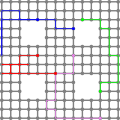

In [7]:
render_grid_graph(G,MultiStageCBS.convert_to_vertex_lists(solution);width=12)

# Experiments:

Generate 4 environments for all experiments

In [1]:
function visualize_env(env::GridFactoryEnvironment;
    vpad = 0.05)
    cw = get_cell_width(env)/2 - vpad
    vtxs = get_vtxs(env)
    xpts = map(vtx->get_cell_width(env)*vtx[1], vtxs)
    ypts = map(vtx->get_cell_width(env)*vtx[2], vtxs)
    plot(
        layer( x=map(vec->vec[1], get_pickup_zones(env)), y=map(vec->vec[2], get_pickup_zones(env)),
            size=[3pt], Geom.point, Theme(default_color="blue") ),
        layer( x=map(vec->vec[1], get_dropoff_zones(env)), y=map(vec->vec[2], get_dropoff_zones(env)),
            size=[3pt], Geom.point, Theme(default_color="green") ),
        layer( xmin=xpts .- cw, xmax=xpts .+ cw, ymin=ypts .- cw, ymax=ypts .+ cw, Geom.rect,
            Theme(default_color="light gray")),
        Coord.cartesian(fixed=true),
        Guide.xticks(;ticks=nothing),
        Guide.yticks(;ticks=nothing),
        Guide.xlabel(nothing),
        Guide.ylabel(nothing)
    )
end

UndefVarError: UndefVarError: GridFactoryEnvironment not defined

In [3]:
experiment_dir = joinpath(dirname(pathof(WebotsSim)),"..","experiments")

UndefVarError: UndefVarError: WebotsSim not defined

In [2]:
env_graphs = []
envs = []
num_obstacle_cells = 64
for (i,n) in enumerate([2,4,8])
    obs_w = Int(sqrt(num_obstacle_cells)/n)
    env = construct_regular_factory_world(;
        n_obstacles_x=n,
        n_obstacles_y=n,
        obs_width = [obs_w;obs_w],
        obs_offset = [obs_w;obs_w],
        env_pad = [1;1],
        env_offset = [1,1],
        env_scale = 1 # this is essentially the robot diameter
    )
    filename = string(experiment_dir,"/env_",i,".toml")
    open(filename,"w") do io
        TOML.print(io,env)
    end
    push!(envs, env)
end

UndefVarError: UndefVarError: construct_regular_factory_world not defined

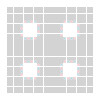

In [56]:
i = 1
filename = string(experiment_dir,"/env_",i,".toml")
env = read_env(filename)
visualize_env(env)

Generate problem instances for all experiments

In [99]:
# solver profiling
num_robots = []
num_tasks = [5,10,20,40,80,120]
depth_biases = [0.1,0.4,0.7,1.0]
processing_time = [0,10,20]
num_trials = 10
M = 5
project_spec = construct_random_project_spec(M;max_parents=4,depth_bias=0.1,Δt_min=0,Δt_max=0)
delivery_graph = construct_delivery_graph(project_spec,M)
plot_graph_bfs(delivery_graph.graph;mode=nothing,fillcolor="orange")

In [ ]:
data_path = joinpath(dirname(pathof(TaskGraphs)),"..","test","profiling")
file_list = readdir(data_path)
num_csv_files = 0
for filename in file_list
    if splitext(filename)[end] == ".csv"
        global num_csv_files += 1
    end
end
# filename = joinpath(data_path, string("MILP_profiling_", num_csv_files, ".csv"))
filename = joinpath(data_path, string("MILP_profiling", ".csv"))
iteration = isfile("profiling/MILP_profiling.csv") ? -countlines("profiling/MILP_profiling.csv")+1 : 0

TRIALS_PER_SETTING = 3;
# iteration = 0;
# run tests and push results into table
for N in [10,20,40,100]
    for M in Vector{Int}([N/2, N, 2*N, 3*N])
        for max_parents in [4]
            for depth_bias in [0.1,0.4,0.7,1.0]
                global iteration
                for trial in 1:TRIALS_PER_SETTING + (-TRIALS_PER_SETTING < iteration <= 0)
                    if iteration < 0
                        iteration += 1
                        continue
                    end
                    df = DataFrame(
                        N = Int[],
                        M = Int[],
                        max_parents=Int[],
                        depth_bias=Float64[],
                        solve_time=Float64[],
                        termination_status=Int[]
                        )
                    r₀,s₀,sₜ = initialize_random_2D_task_graph_env(N,M;d=[40,40])
                    Drs, Dss = cached_pickup_and_delivery_distances(r₀,s₀,sₜ)
                    project_spec = construct_random_project_spec(M;max_parents=max_parents,depth_bias=depth_bias,Δt_min=0,Δt_max=0)
                    delivery_graph = construct_delivery_graph(project_spec,M)
                    G = delivery_graph.graph
                    # initialize vector of operation times
                    Δt = zeros(nv(G)) # Δt[j] is the wait time for the object j to appear once all inputs have been satisfied
                    for op in project_spec.operations
                        for id in get_output_ids(op)
                            Δt[id] = duration(op)
                        end
                    end
                    # set initial conditions
                    to0_ = Dict{Int,Float64}()
                    for v in vertices(G)
                        if is_root_node(G,v)
                            to0_[v] = 0.0
                        end
                    end
                    tr0_ = Dict{Int,Float64}()
                    for i in 1:N
                        tr0_[i] = 0.0
                    end
                    # formulate MILP
                    model = formulate_optimization_problem(
                        G,Drs,Dss,Δt,to0_,tr0_,
                        Gurobi.Optimizer;TimeLimit=10);
                    # Solve!
                    start_time = time()
                    optimize!(model)
                    solve_time = time() - start_time

                    global iteration
                    if iteration > 0
                        row_dict = Dict(
                            :N => N,
                            :M => M,
                            :max_parents => max_parents,
                            :depth_bias => depth_bias,
                            :solve_time => solve_time,
                            :termination_status => Int(termination_status(model))
                            )
                        push!(df, row_dict)
                        file = open(filename;append=true)
                        if countlines(filename) == 0
                            df |> CSV.write(file;writeheader=true)
                        else
                            df |> CSV.write(file;append=true)
                        end
                        close(file)
                        for k in sort(collect(keys(row_dict)))
                            print(string(k),": ",row_dict[k],", ")
                        end
                        print("\n")
                    end
                    iteration += 1
                end
            end
        end
    end
end

# 1. Profiling Solver

# 2. Profiling Multi-Stage CBS Path Planner (FIX ISSUE FIRST!)

# 3. Profiling Optimal Combined Assignment and Path Planning